In [1]:
!pip install cdp_data[transformers]
!pip install python-docx
!pip install pypdf2
!pip install dtw-python
!pip install fastdtw

In [2]:
from cdp_data import CDPInstances, datasets

sessions_df = datasets.get_session_dataset(
    CDPInstances.Seattle,
    start_datetime="2022-04-12",
    end_datetime="2022-04-13",
    store_transcript=True,
    store_transcript_as_csv=True,
    replace_py_objects=True,
)
sessions_df

Fetching each model attached to event_ref:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/2 [00:00<?, ?it/s]

Converting and storing each transcript as a CSV: 2it [00:02,  1.41s/it]


,session_datetime,session_index,session_content_hash,video_uri,video_start_time,video_end_time,caption_uri,external_source_id,id,key,transcript_path,transcript_as_csv_path,event_id,transcript_id
0,2022-04-12 16:30:00+00:00,0,f0cae98bc2d6d98a862ed327cbfff87a27001f2c8e0e7a...,https://video.seattle.gov/media/council/safe_0...,None,None,https://www.seattlechannel.org/documents/seatt...,None,0aa1f8fcd0ad,session/0aa1f8fcd0ad,/home/eva/active/pit/cdp-minutes-item-generati...,/home/eva/active/pit/cdp-minutes-item-generati...,191da1d7a5c1,cef2d7d8c652
1,2022-04-12 21:00:00+00:00,0,0a4cd39c037472b255d89277f5d13ccf8d9fe5b720620f...,https://video.seattle.gov/media/council/counci...,None,None,https://www.seattlechannel.org/documents/seatt...,None,1e8f2e1bd894,session/1e8f2e1bd894,/home/eva/active/pit/cdp-minutes-item-generati...,/home/eva/active/pit/cdp-minutes-item-generati...,68b57858cc30,38f78abe3032


In [3]:
import pandas as pd

example_t_path = sessions_df.iloc[0].transcript_as_csv_path
example_e_id = sessions_df.iloc[0].event_id
example_t = pd.read_csv(example_t_path)
example_t

,index,confidence,start_time,end_time,text,speaker_index,speaker_name,annotations
0,0,0.97,14.647,17.183,Thank you so much.,0,NaN,NaN
1,1,0.97,17.183,17.517,Good morning.,0,NaN,NaN
2,2,0.97,17.517,23.056,"April 12, 2022 meeting of the public safety an...",0,NaN,NaN
3,3,0.97,23.056,25.058,It is now 9:30 A.M.,0,NaN,NaN
4,4,0.97,25.058,27.894,"I'm Lisa Herbold, chair of the committee.",0,NaN,NaN
...,...,...,...,...,...,...,...,...
1471,1471,0.97,12306.594,12311.899,I just want to note the time is 12:58.,194,NaN,NaN
1472,1472,0.97,12311.899,12315.970,There were no further comments from my colleag...,194,NaN,NaN
1473,1473,0.97,12315.970,12320.408,Hearing and seeing none.,194,NaN,NaN
1474,1474,0.97,12320.408,12321.208,Thank you so much.,194,NaN,NaN


In [4]:
from cdp_backend.utils.file_utils import resource_copy
import docx
from pathlib import Path
from uuid import uuid4
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer

def process_document(doc_path):
    # Try docx
    try:
        doc = docx.Document(doc_path)
        texts = []
        for para in doc.paragraphs:
            this_text = para.text.strip()
            if len(this_text) > 0:
                texts.append(this_text)

        # If we found text
        # This was a docx file
        if len(texts) > 0:
            return texts

        # If we didn't find text, it was still a docx file
        # that we just failed to parse
        # No need to try anything else in that case, just return
        return None

    # Try pdf
    except:
        try:
            reader = PdfReader(doc_path)
            texts = []
            for page in reader.pages:
                this_page_text = page.extract_text().strip()
                for para in this_page_text.split("\n"):
                    para_cleaned = para.strip()
                    if len(para_cleaned) > 0:
                        texts.append(para_cleaned)
            
            # If we found text
            # This was a pdf file
            if len(texts) > 0:
                return texts

            # If we didn't find text, it was still a pdf file
            # That we just failed to parse
            return None
        
        # It wasn't either file format
        except:
            return None

def process_file(file_model):
    try:
        # Create temp store path
        temp_store_path = Path(f"temp_{uuid4()}")

        # Store remote to local
        temp_store_path = Path(
            resource_copy(file_model.uri, dst=temp_store_path, overwrite=True),
        )

        # Get document content
        texts = process_document(temp_store_path)

        # Handle file not supported
        if texts is None:
            return None

        # Otherwise proceed
        # Encode all texts and then get the average vector
        model = SentenceTransformer("all-mpnet-base-v2")
        return model.encode(texts).mean(axis=0)
    
    # Always clear file
    finally:
        temp_store_path.unlink(missing_ok=True)

In [5]:
from cdp_data import CDPInstances
from cdp_data.utils import connect_to_infrastructure
from cdp_backend.database import models as db_models
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# Ignore resource copy warnings
import warnings
warnings.filterwarnings("ignore", message=".*Unverified HTTPS request is being made to host.*")

# Connect to seattle
connect_to_infrastructure(CDPInstances.Seattle)

# Load model
model = SentenceTransformer("all-mpnet-base-v2")

# Pull event minutes items
emis = list(
    db_models.EventMinutesItem.collection.filter(
        "event_ref", "==", f"{db_models.Event.collection_name}/{example_e_id}"
    ).order("index").fetch()
)

# Process event minutes items
processed_emis = []
for emi in tqdm(emis):
    # Encode the minutes item name
    mi = emi.minutes_item_ref.get()
    full_mi_name = mi.name
    if mi.description is not None:
        full_mi_name = f"{full_mi_name} {mi.description}"
    
    name_vec = model.encode([full_mi_name])[0]

    # Encode all supporting docs (if there are any)
    files = list(db_models.EventMinutesItemFile.collection.filter("event_minutes_item_ref", "==", emi.key).fetch())
    file_vecs = []
    for file_model in files:
        vec_or_none = process_file(file_model)
        if vec_or_none is not None:
            file_vecs.append(vec_or_none)
    
    # Average everything together
    emi_encoding = np.stack([name_vec, *file_vecs], axis=0).mean(axis=0)
    processed_emis.append({
        "vec": emi_encoding,
        "name": full_mi_name,
        "index": emi.index,
    })
    
processed_emis_just_vecs = [emi["vec"] for emi in processed_emis]

100%|██████████| 8/8 [00:22<00:00,  2.84s/it]


In [6]:
windowed_sentences = (
    example_t.text.shift(2)
    + " " + example_t.text.shift(1)
    + " " + example_t.text
    + " " + example_t.text.shift(-1)
    + " " + example_t.text.shift(-2)
)
windowed_sentences = windowed_sentences.fillna("START OR END")

In [7]:
sentence_embeddings = model.encode(windowed_sentences)
sentence_embeddings_list = sentence_embeddings.tolist()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<AxesSubplot: xlabel='Query index', ylabel='Reference index'>

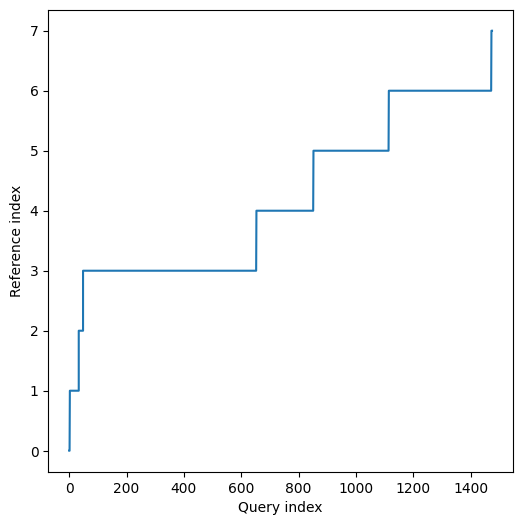

In [8]:
from dtw import dtw

result = dtw(
    sentence_embeddings_list,
    processed_emis_just_vecs,
    dist_method="cosine",
)
result.plot()

In [9]:
result.index2[:15]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
from fastdtw import fastdtw
from scipy.spatial.distance import cosine

distance, path = fastdtw(sentence_embeddings_list, processed_emis_just_vecs, dist=cosine)

# print(distance)
print(path[:15])

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3)]


In [11]:
example_t["minutes_item"] = [
    processed_emis[minute_index]["name"] for _, minute_index in path
]
example_t

,index,confidence,start_time,end_time,text,speaker_index,speaker_name,annotations,minutes_item
0,0,0.97,14.647,17.183,Thank you so much.,0,NaN,NaN,Call To Order
1,1,0.97,17.183,17.517,Good morning.,0,NaN,NaN,Approval of the Agenda
2,2,0.97,17.517,23.056,"April 12, 2022 meeting of the public safety an...",0,NaN,NaN,Public Comment
3,3,0.97,23.056,25.058,It is now 9:30 A.M.,0,NaN,NaN,Inf 2035 Update on Statement of Legislative In...
4,4,0.97,25.058,27.894,"I'm Lisa Herbold, chair of the committee.",0,NaN,NaN,Inf 2035 Update on Statement of Legislative In...
...,...,...,...,...,...,...,...,...,...
1471,1471,0.97,12306.594,12311.899,I just want to note the time is 12:58.,194,NaN,NaN,Adjournment
1472,1472,0.97,12311.899,12315.970,There were no further comments from my colleag...,194,NaN,NaN,Adjournment
1473,1473,0.97,12315.970,12320.408,Hearing and seeing none.,194,NaN,NaN,Adjournment
1474,1474,0.97,12320.408,12321.208,Thank you so much.,194,NaN,NaN,Adjournment


In [12]:
example_t.to_csv("dtw-transcript.csv", index=False)